# 0. General Resources for PypeIt/DeVeny:

- Documentation page for Pypeit: https://pypeit.readthedocs.io/en/release/
- DeVeny Manual (see section I): http://www2.lowell.edu/users/tbowers/DevenyManualv18-dev.pdf

# 1. Reduction Steps tl;dr

1. Put all frames (science, cals) into a single directory, open command line and navigate to this directory. Activate conda environment where pypeit is installed if applicable.


2. On command line, in the directory, run:

     ```pypeit_setup -s ldt_deveny```
    
    Examine human readable logs in ```setup_files/``` to make sure all is as expected according to your logsheet.
    
    
3. In the parent working directory, run:

   ```pypeit_setup -s ldt_deveny -c all```

   A new folder for each instument configuration has been generated in ```ldt_deveny_*/ldt_deveny_*.pypeit``` (where * is the name of one of the setups) Mislabeled headers (e.g. if you called a science frame a flat on accident) can be fixed at this point manually before next step. Can also exclude certain frames, e.g. if you over exposed a flat or did arcs with the wrong slit width by excluding these files from list in the ```.pypeit``` file by commenting them out (```#```)
   
   
4. For bright objects like standard stars or particularly big asteroids (e.g. mag < 13 or so), I highly recommend adding:

    ```
    [reduce]
       [[findobj]]
           maxnumber_sci = 1
    ```
    
    in the user-defined parameters section (~line 4). For faint objects, this should also work, but take care for faint objects in a crowded field and make sure the brightest detection actually is the object (an object centered in the slit should show up as a well centered trace in the raw fits image. More on how to evaluate this later). Another good option is to use sigma-clipping to make sure detected objects are above a certain signal-to-noise level, and you can read about that here (https://pypeit.readthedocs.io/en/release/pypeit_par.html#findobjpar-keywords)
    
    
    
5. Now, running PypeIt for each instrument configuration. From now on we are in the instrument configuration subfolder, e.g. ```cd ldt_deveny_A``` in your commandline:

   a. Run PypeIt on the calibrations with ```run_pypeit ldt_deveny_*.pypeit -c``` (where * is the name of the setup you are using, in ldt_deveny_A, this is A). This step can take a long time so using the ```-c``` flag to run just on calibration frames allows you to inspect the calibration frames before running the full reduction so you don't waste time reducing data with (potentially suspect) calibration frames.

   b. Examine the calibrations in the calibrations subfolder. Check that the normalized flat has values all around 1 using the ```pypeit_chk_flats``` tool, e.g. ```pypeit_chk_flats Calibrations/Flat_A_0_DET01.fits``` (adjust filename as appropriate). Flats should have pixel values near 1 throughout the flat. You can also visually examine the images in ```/QA/PNGs/``` to check that the arc line identification looks okay. 
   
   c. If so, process the science images with ```run_pypeit ldt_deveny_*.pypeit``` (again replacing * with the name of the setup you are using). This will take a long time (~20 sec per image?), go get lunch.
   
   d. There are several ways to make sure that PypeIt identified the object you wanted it to:
   
      - In ```/QA/PNGs``` you can investigate files of the format ```*_obj_prof.png```, which gives you a PNG image of the line profile and shows which objects were detected and extracted and which ones were rejected and why. A well-centered object in the slit will be towards the middle of this profile. 
      
      - To examine an individual frame in more detail, run the command ```pypeit_show_2d [filename]``` on one of the ```Science/2pec2d*.fits``` files. This will open a GUI that identifies and names each detection and highlights it on the screen so you can visually inspect frames with multiple detections to ensure that you can identify the one you'd like to extract in the case of multiple detections.
      
   e. To quickly examine the extracted object spectra, run ```pypeit_chk_noise_1dspec spec1d*.fits``` to quickly scan through all the 1d spectra to look for obvious artifacts. DeVeny in particular is succeptible to periodic noise during readout, these frames can be excluded or alternatively try the denoising procedures in section E of the DeVeny manual.
      
   f. Once you have identified the correct detections, it's time to co-add images of the same object. You need to generate a coadd1d file in a text editor (see https://pypeit.readthedocs.io/en/release/coadd1d.html) for details. For asteroids (or other reflectance measurements), we need to put ```flux_value = False``` in the parameter block since we won't be doing an absolute flux calibration. The names of the detections needed to build the coadd1d file can be found in the ```Science/spec1d*.txt``` files.
   
   g. After building the coadd1d file, navigate to the directory where you saved it and run ```pypeit_coadd_1dspec [file name here] --show```, which will display the coadded spectrum. Complete steps e & f for each object. 
   
   
   
6. Now you should have a combined coadd file for each object and can move on to the post-processing steps below!

# 2. Useful Python functions for Reduction

In [1]:
# version of the packages I am using are noted below
import matplotlib.pyplot as plt # matplotlib 3.7.2
import numpy as np # numpy 1.24.3
from astropy.io import fits # astropy 5.3.1
from astropy.table import Table 
from astropy.io import ascii
from scipy.interpolate import interp1d # scipy 1.11.1

def fits_import(filename):
    '''Convenience function for importing and reading PypeIt data files
    
    Caution: This function assumes a specific format for the FITS files!
    If PypeIt file conventions change, this code may not work as expected!
    See comments for details. 
    
    Parameters
    ----------
    filename : str
        path to the .fits file output by PypeIt to be read

    Returns
    -------
    astropy.table.Table
        A table containing the data from the .fits file with the following columns
            wave: wavelength (in angstroms)
            wave_grid_mid: wavelength grid midpoints (in angstroms)
            flux: relative measure of flux (arbitrary units)
            flux error: error in relative flux (arbitrary units)
            ivar: inverse variance in relative flux (arbitrary units)
            
    See Also
    -------
    astropy.io.fits
    '''
    with fits.open(filename) as hdul:  # open a FITS file

        # hdul[0] holds some header info from the original fits file, and no data
        # hdul[1] holds the extracted data
        data = hdul[1].data
        # the names of the variables below come from the header hdul[1].header
        ## wavelengths of the bins in angstroms
        wave = [i[0] for i in data]
        ## midpoints of the wavelength grids in angstroms
        wave_grid_mid = [i[1] for i in data]
        ## flux in arbitrary units, as we didn't flux the data 
        flux = [i[2] for i in data]
        ## ivar or inverse variance in flux: ivar = 1/(error)**2
        ivar = [i[3] for i in data]
        ## I like using error better so I will add it to the table
        error = np.sqrt(1/np.asarray(ivar))
        ## mask--flag for bad data. 
        mask = [i[4] for i in data]
        #build the table
        t = Table([wave, wave_grid_mid, flux, error, ivar], \
                  names = ['wave', 'wave_grid_mid', 'flux', 'flux error', 'ivar'])
        t = t[np.asarray(mask)==1]
        return t
    
def solar_correct(aster, stand, norm_to = False, norm_width = False):
    '''
    Divides one spectrum (aster) by another (stand)
    
    Typical use case is dividing an asteroid spectrum by a solar standard 
    to convert to from arbitrary flux to reflectance
    
    Parameters
    ----------
    aster: astropy.table.Table with columns 'wave', 'flux', and 'flux error' as output by fits_import()
           contains the data for an asteroid (typical use)
    
    stand: astropy.table.Table with columns 'wave', 'flux', and 'flux error' as output by fits_import()
           contains the data for a solar standard (typical use)
           
    norm_to: int or float, wavelength in angstroms to normalize output spectrum to. Default is 5500 A. 
    
    norm_width: half-width of the window around norm_to used to calculate the value of the divided spectrum at norm_to

    Returns
    -------
    astropy.table.Table
        A table containing the divided spectrum t = aster/stand (and associated errors) with the following columns
            wave: wavelength (in angstroms)
            wave_grid_mid: wavelength grid midpoints (in angstroms)
            flux: relative measure of flux (arbitrary units)
            flux error: error in relative flux (arbitrary units)
            ivar: inverse variance in relative flux (arbitrary units)
            
    See Also
    -------
    fits_import() 
    divide aster by stand 
        - resample standard to the same wavelengths as asteroid
        - divide aster by stand
        - normalize at 5500 A
    '''
    if not norm_to: 
        norm_to = 5500
    if not norm_width:
        norm_width = 100
    wave = aster['wave']
    s_flux = interp1d(stand['wave'], stand['flux'], fill_value = 'extrapolate')
    s_ferr = interp1d(stand['wave'], stand['flux error'], fill_value = 'extrapolate')
    stand_flux = s_flux(wave)
    stand_ferr = s_ferr(wave)
    aster_flux = aster['flux']
    aster_ferr = aster['flux error']
    # both must be 1, eg, good, to pass muster
    # new_mask = np.logical_and(aster['mask'], stand['mask'])
    new_ref = aster_flux/stand_flux
    new_err = np.abs(new_ref*np.sqrt((aster_ferr/aster_flux)**2 +(stand_ferr/stand_flux)**2))
    # now normalizing
    filt1 = wave < norm_to + norm_width
    filt2 = wave > norm_to - norm_width
    filt = np.logical_and(filt1, filt2)
    p = np.poly1d(np.polyfit(wave[filt], new_ref[filt], 1))
    scale = p(norm_to)
    t = Table([wave, aster['wave_grid_mid'], new_ref/scale, new_err/scale, (scale/new_err)**2],\
             names = ['wave', 'wave_grid_mid', 'flux', 'flux error', 'ivar'])
    return t

def weighted_average(dataset, weights):
    '''
    Computes the weighted average of a list of datasets according to weights
    
    Typical use case is dividing an asteroid spectrum by a solar standard 
    to convert to from arbitrary flux to reflectance
    
    Parameters
    ----------
    dataset: array-like, a list of astropy.table.Table objects with columns 'wave', 'flux', and 'flux error' 
    
    weights: array-like, a list of floats representing the weighting given to the ith entry in dataset. 
             this array does not need to be normalized (e.g. add up to 1), that is done automatically. 
           
    Returns
    -------
    astropy.table.Table
        A table containing the divided spectrum t = aster/stand (and associated errors) with the following columns
            wave: wavelength (in angstroms)
            wave_grid_mid: wavelength grid midpoints (in angstroms)
            flux: relative measure of flux (arbitrary units)
            flux error: error in relative flux (arbitrary units)
            ivar: inverse variance in relative flux (arbitrary units)
            
    See Also
    -------
    fits_import() 
    divide aster by stand 
        - resample standard to the same wavelengths as asteroid
        - divide aster by stand
        - normalize at 5500 A
    '''    
    wave = dataset[0]['wave']
    avg_flux = np.zeros(np.shape(wave))
    avg_err = np.zeros(np.shape(wave))
    weights = weights/np.sum(weights)
    for i in range(len(dataset)):
        avg_flux += weights[i] * dataset[i]['flux']
        avg_err += weights[i]**2 * dataset[i]['flux error']**2
    avg_err = np.sqrt(avg_err)
    ivar = 1 / (avg_err**2)
    t = Table([wave, dataset[0]['wave_grid_mid'], avg_flux, avg_err, ivar], \
              names = ['wave', 'wave_grid_mid', 'flux', 'flux error', 'ivar'])
    return t

# 3. Example Reduction with 32144 Humes


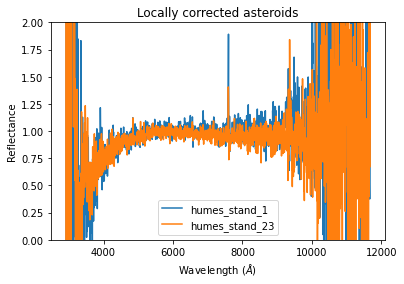

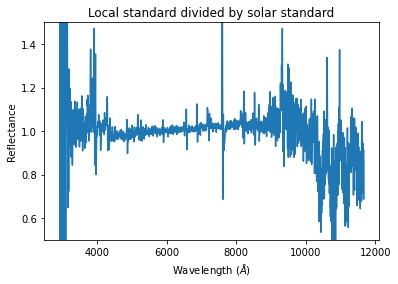

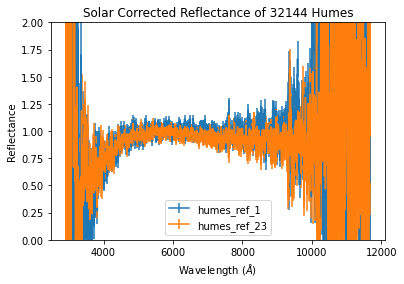

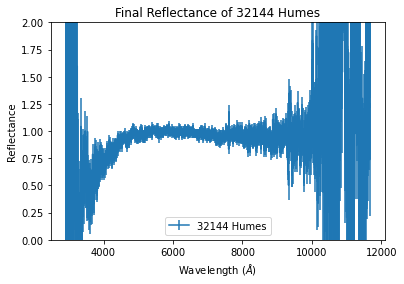

In [2]:
# importing the data

# some info about the data: 
# 'humes' is the asteroid (32144) Humes
# 'stand' is the local standard (HD 210335)
#         a solar-like star near Humes
# 'solar' is a well-characterized solar standard star (SA 110-361)
#         it is not near either Humes or HD 210335

# humes_1 and stand_1 are a set of coadded observations taken at about the same time/airmass
# Similarly, humes_23 and stand_23 are a set of coadded observations taken at about the same time/airmass
# solar is the set of coadded observations of SA 110-361 taken at 1.5 airmasses
# stand_2 is the set of observations taken when HD 210335 was at the same airmass as SA 110-361

humes_1 = fits_import('Example Data/32144Humes_1.fits')
humes_23 = fits_import('Example Data/32144Humes_23.fits')

stand_1 = fits_import('Example Data/HD210335_1.fits')
stand_23 = fits_import('Example Data/HD210335_23.fits')

solar = fits_import('Example Data/SA110-361.fits')
stand_2 = fits_import('Example Data/HD210335_2.fits')

# first, we will compute the reflectance spectra of Humes by dividing by the local standard

humes_stand_1 = solar_correct(humes_1, stand_1)
plt.plot(humes_stand_1['wave'], humes_stand_1['flux'], label = 'humes_stand_1')


humes_stand_23 = solar_correct(humes_23, stand_23)
plt.plot(humes_stand_23['wave'], humes_stand_23['flux'], label = 'humes_stand_23')

# plot parameters
# since reflectance is normalized, 0-2 is an appropriate ylim. 
plt.ylim(0, 2)
plt.title('Locally corrected asteroids')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()
plt.show()

# we can use the same solar_correct function to compare the local and solar standards taken at the same airmass
# ideally this spectrum should be pretty flat. Computing this will also help us to do a finer correction later
# to account for differences between the local standard and the well characterized solar analog
# for these observations, we put the solar analog as the first argument and the local standards as the second

solar_stand = solar_correct(solar, stand_2)
plt.plot(solar_stand['wave'], solar_stand['flux'])
# should be pretty close to flat
plt.ylim(0.5, 1.5)
plt.title('Local standard divided by solar standard')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength ($\AA$)')
plt.show()

# now if we divide the locally corrected asteroid spectrum by the above spectrum we have corrected 
# for both local atmospheric transparency and for solar reflectance!

humes_ref_1 = solar_correct(humes_stand_1, solar_stand)
humes_ref_23 = solar_correct(humes_stand_23, solar_stand)

plt.errorbar(humes_ref_1['wave'], humes_ref_1['flux'], yerr = humes_ref_1['flux error'], label = 'humes_ref_1')
plt.errorbar(humes_ref_23['wave'], humes_ref_23['flux'], yerr = humes_ref_23['flux error'], label = 'humes_ref_23')

plt.ylim(0, 2)
plt.title('Solar Corrected Reflectance of 32144 Humes')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()
plt.show()

# Since the local corrections are done, we can now co-add the asteroid spectra into a single combined spectrum
# In this case, both humes_1 and humes_23 combine five observations of 300 seconds each
# so we weight them the same to average them together.

humes_ref = weighted_average([humes_ref_1, humes_ref_23], [1,1])

plt.errorbar(humes_ref['wave'], humes_ref['flux'], yerr = humes_ref['flux error'], label = '32144 Humes')
plt.ylim(0, 2)
plt.title('Final Reflectance of 32144 Humes')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()
plt.show()

# 4. Useful Python functions for classification

In [92]:
# If used, cite https://doi.org/10.1016/j.icarus.2009.02.005
# Channel means are drawn from MMC 4 of this article

bd_table = ascii.read('BD-tax-channel_means.txt')

# to be added!

# 5. Example Classification with 32144 Humes

In [ ]:
# to be added!